In [20]:
from tqdm import tqdm
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
import torchvision.transforms as transforms
import medmnist
from medmnist import INFO, Evaluator

In [21]:
print(f"MedMNIST v{medmnist.__version__} @ {medmnist.HOMEPAGE}")

MedMNIST v3.0.2 @ https://github.com/MedMNIST/MedMNIST/


# We first work on a 2D dataset with size 28x28

In [22]:
data_flag = 'dermamnist'
download = True
BATCH_SIZE = 64

info = INFO[data_flag]
task = info['task']
n_channels = info['n_channels']
n_classes = len(info['label'])

DataClass = getattr(medmnist, info['python_class'])

## First, we read the MedMNIST data, preprocess them and encapsulate them into dataloader form.

In [23]:
# preprocessing
data_transform = transforms.Compose([
    transforms.ToTensor(),
])

# load the data
train_dataset = DataClass(split='train', transform=data_transform, download=download)
test_dataset = DataClass(split='test', transform=data_transform, download=download)

# ?
validation_dataset = DataClass(split='val', transform=data_transform, download=download)

pil_dataset = DataClass(split='train', download=download)

# encapsulate data into dataloader form
train_loader = data.DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True)
train_loader_at_eval = data.DataLoader(dataset=train_dataset, batch_size=2*BATCH_SIZE, shuffle=False)
test_loader = data.DataLoader(dataset=test_dataset, batch_size=2*BATCH_SIZE, shuffle=False)

validation_loader = data.DataLoader(dataset=validation_dataset, batch_size=2*BATCH_SIZE, shuffle=False)

Using downloaded and verified file: C:\Users\josem\.medmnist\dermamnist.npz
Using downloaded and verified file: C:\Users\josem\.medmnist\dermamnist.npz
Using downloaded and verified file: C:\Users\josem\.medmnist\dermamnist.npz
Using downloaded and verified file: C:\Users\josem\.medmnist\dermamnist.npz


In [24]:
print(train_dataset)
print("===================")
print(test_dataset)

Dataset DermaMNIST of size 28 (dermamnist)
    Number of datapoints: 7007
    Root location: C:\Users\josem\.medmnist
    Split: train
    Task: multi-class
    Number of channels: 3
    Meaning of labels: {'0': 'actinic keratoses and intraepithelial carcinoma', '1': 'basal cell carcinoma', '2': 'benign keratosis-like lesions', '3': 'dermatofibroma', '4': 'melanoma', '5': 'melanocytic nevi', '6': 'vascular lesions'}
    Number of samples: {'train': 7007, 'val': 1003, 'test': 2005}
    Description: The DermaMNIST is based on the HAM10000, a large collection of multi-source dermatoscopic images of common pigmented skin lesions. The dataset consists of 10,015 dermatoscopic images categorized as 7 different diseases, formulized as a multi-class classification task. We split the images into training, validation and test set with a ratio of 7:1:2. The source images of 3×600×450 are resized into 3×28×28.
    License: CC BY-NC 4.0
Dataset DermaMNIST of size 28 (dermamnist)
    Number of datapo

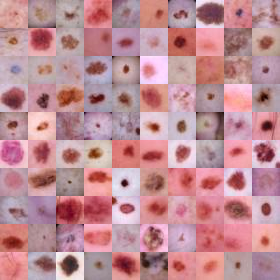

In [25]:
# montage

train_dataset.montage(length=10)

In [50]:
import numpy as np
from collections import Counter

# Initialize an empty list to store labels
train_labels = []
test_labels = []
validation_labels = []

# Use a dataloader to extract labels in batches
for _, labels in train_loader_at_eval:
    # Convert numpy arrays to integers before adding to list
    train_labels.extend(labels.cpu().numpy().flatten().tolist())

for _, labels in test_loader:
    test_labels.extend(labels.cpu().numpy().flatten().tolist())
    
for _, labels in validation_loader:
    validation_labels.extend(labels.cpu().numpy().flatten().tolist())
    
# Count the number of occurrences of each label
train_label_counts = Counter(train_labels)
test_label_counts = Counter(test_labels)
validation_label_counts = Counter(validation_labels)

# Print the counts
print("Train label counts:")
print(train_label_counts)
print("Test label counts:")
print(test_label_counts)
print("Validation label counts:")
print(validation_label_counts)


Train label counts:
Counter({5: 4693, 4: 779, 2: 769, 1: 359, 0: 228, 6: 99, 3: 80})
Test label counts:
Counter({5: 1341, 4: 223, 2: 220, 1: 103, 0: 66, 6: 29, 3: 23})
Validation label counts:
Counter({5: 671, 4: 111, 2: 110, 1: 52, 0: 33, 6: 14, 3: 12})


In [26]:
if torch.backends.mps.is_available():
    device = torch.device("mps")
elif torch.cuda.is_available():    
    device = torch.device("cuda")
else:
    device = torch.device("cpu")
    
print(f"Device: {device}")

Device: cuda


## 1. MLP 

In [27]:
def validation(validation_data, nn, criterion, to_device=True):
    if to_device:
        nn = nn.to(device)

    # Validation
    loss = 0

    with torch.no_grad():
        for X_train, y_train in validation_data:

            # send everything to the device (ideally a GPU)
            if to_device:
                X_train = X_train.to(device)
                y_train = y_train.to(device)

            # Flatten RGB images into a single vector
            X_train = X_train.view(X_train.size(0), -1)

            # Remove unused dimension and convert to long
            y_train = y_train.squeeze().long()

            # Forward pass
            outputs = nn(X_train)
            loss += criterion(outputs, y_train).item()

    loss /= len(validation_data)
    return loss

In [28]:
def fit(
    training_data,
    validation_data,
    nn,
    criterion,
    optimizer,
    n_epochs,
    to_device=True,
):

    # send everything to the device (ideally a GPU)
    if to_device:
        nn = nn.to(device)

    # Train the network
    loss_values = {
        "train": [],
        "validation": [],
    }
    for epoch in range(n_epochs):
        accu_loss = 0

        for X_train, y_train in training_data:

            # send everything to the device (ideally a GPU)
            if to_device:
                X_train = X_train.to(device)
                y_train = y_train.to(device)

            # Flatten RGB images into a single vector
            X_train = X_train.view(X_train.size(0), -1)

            # Remove unused dimension and convert to long
            y_train = y_train.squeeze().long()

            # Forward pass
            outputs = nn(X_train)
            loss = criterion(outputs, y_train)

            # Backward and optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            accu_loss += loss.item()

        accu_loss /= len(training_data)

        # if (epoch+1) % 10 == 0:
        loss_values["train"].append(accu_loss)

        # Validation
        val_loss = validation(validation_data, nn, criterion, to_device)
        loss_values["validation"].append(val_loss)
        
        # if (epoch+1) % 10 == 0:
        print(f"Epoch [{epoch+1}/{n_epochs}], Training Loss: {accu_loss}, Validation Loss: {val_loss}")

    return loss_values, nn.to("cpu")

In [29]:
# No of Neurons in Input Layer
input_size = n_channels * train_dataset[0][0].shape[1] * train_dataset[0][0].shape[2]
# No of Neurons in Hidden Layers
hidden_sizes = [256, 128]
# No of Neurons in Output Layer
num_classes = n_classes

Model:
MLP(
  (layers): ModuleList(
    (0): Linear(in_features=2352, out_features=1179, bias=True)
    (1-4): 4 x Linear(in_features=1179, out_features=1179, bias=True)
    (5): Linear(in_features=1179, out_features=7, bias=True)
  )
  (activations): ModuleList(
    (0-4): 5 x ReLU()
  )
)
Epoch [1/25], Training Loss: 17.714510118419472, Validation Loss: 1.27534681558609
Epoch [2/25], Training Loss: 1.2800231267105449, Validation Loss: 1.2964605018496513
Epoch [3/25], Training Loss: 1.2364232469688763, Validation Loss: 1.1954357251524925
Epoch [4/25], Training Loss: 1.2268296073783527, Validation Loss: 1.243685245513916
Epoch [5/25], Training Loss: 1.231336579539559, Validation Loss: 1.2413945719599724
Epoch [6/25], Training Loss: 1.2138528802178123, Validation Loss: 1.2129048109054565
Epoch [7/25], Training Loss: 1.2119349972768263, Validation Loss: 1.2827099859714508
Epoch [8/25], Training Loss: 1.2043248436667702, Validation Loss: 1.171018823981285
Epoch [9/25], Training Loss: 1.17

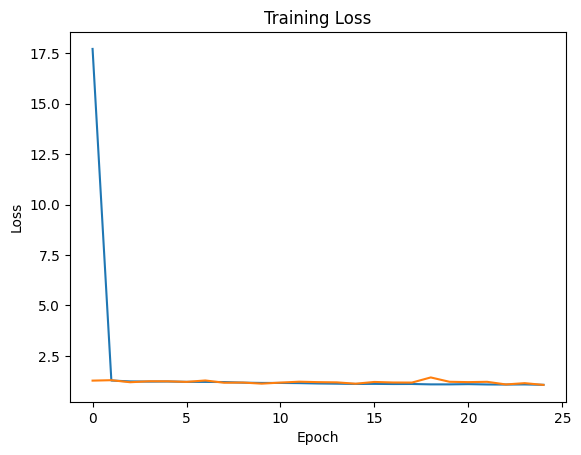

In [30]:
from custom_models.mlp import MLP

# Create the network, define criterion and optimizer
n_epochs = 25
BATCH_SIZE = 64
n_layers = 5

# Determine the number of classes
hidden_layer_sizes = ((input_size + num_classes) // 2,) * n_layers
mlp = MLP(
    input_size=input_size, hidden_sizes=hidden_layer_sizes, num_classes=num_classes
)

print("Model:")
print(mlp)

# Loss Function
# this criterion combines nn.LogSoftmax() and nn.NLLLoss() in one single class.
# It expects the target to be class indices (not one-hot encoded)
criterion = nn.CrossEntropyLoss()

#criterion = nn.MultiMarginLoss()

# Optimizer
optimizer = optim.RMSprop(mlp.parameters(), lr=0.001)

mlp_loss_values, mlp = fit(
    training_data=train_loader,
    validation_data=validation_loader,
    nn=mlp,
    criterion=criterion,
    optimizer=optimizer,
    n_epochs=n_epochs,
    to_device=True,
)

# Plot the loss values over time
import matplotlib.pyplot as plt

plt.plot(mlp_loss_values["train"], label="Training Loss")
plt.plot(mlp_loss_values["validation"], label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training Loss")
plt.show()


In [31]:
from sklearn.metrics import confusion_matrix, f1_score

def evaluate_model(model, test_dataloader, num_classes):
    model.eval()
    total_samples = 0
    correct_samples = 0
    all_labels = []
    all_preds = []
    
    model.to(device)
    
    with torch.no_grad():
        for data, labels in test_dataloader:
            outputs = model(data)
            _, preds = torch.max(outputs, dim=1)
            
            # Accumulate labels and predictions for confusion matrix and F1 score
            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(preds.cpu().numpy())
            
            # Compute accuracy
            correct_samples += (preds == labels).sum().item()
            total_samples += labels.size(0)
    
    # Compute accuracy
    accuracy = correct_samples / total_samples
    
    # Compute confusion matrix
    conf_mat = confusion_matrix(all_labels, all_preds)
    
    # Compute F1 score
    f1 = f1_score(all_labels, all_preds, average='macro')
    
    return accuracy, conf_mat, f1

def evaluate_network(nn, test_data, to_device=True):
    # Set the model to evaluation mode
    nn.eval()
    
    total_samples = 0
    correct_samples = 0
    all_labels = []
    all_preds = []

    if to_device:
        nn = nn.to(device)

    total_samples = len(test_data.dataset)
    correct_sample_predictions = 0

    # Run the model on the test data
    with torch.no_grad():
        for X, y in test_data:
            
            if to_device:
                X = X.to(device)
                y = y.to(device)
                
            # Flatten RGB images into a single vector
            X = X.view(X.size(0), -1)

            # Remove unused dimension and convert to long
            y = y.squeeze().long()

            # Forward pass
            outputs = nn(X)

            # Get the predicted class
            _, predicted = torch.max(outputs, 1)
            
            # Accumulate labels and predictions for confusion matrix and F1 score
            all_labels.extend(y.cpu().numpy())
            all_preds.extend(predicted.cpu().numpy())
            
            # Compute accuracy
            correct_sample_predictions += (predicted == y).sum().item()
            
    # Compute accuracy
    accuracy = correct_sample_predictions / total_samples
    
    # Compute confusion matrix
    conf_mat = confusion_matrix(all_labels, all_preds)
    
    # Compute F1 score
    f1 = f1_score(all_labels, all_preds, average='macro')
    
    return accuracy, conf_mat, f1

In [37]:
def print_7_class_confusion_matrix(conf_matrix):
    print("Confusion Matrix:")
    print("True\Pred\n", end="")
    for i in range(7):
        print(f"\t{i}", end="")
    print()
    for i in range(7):
        print(f"{i}", end="")
        for j in range(7):
            print(f"\t{conf_matrix[i][j]}", end="")
        print()

<>:3: SyntaxWarning: invalid escape sequence '\P'
<>:3: SyntaxWarning: invalid escape sequence '\P'
C:\Users\josem\AppData\Local\Temp\ipykernel_15044\688892838.py:3: SyntaxWarning: invalid escape sequence '\P'
  print("True\Pred\n", end="")


In [38]:
print('Evaluating with the training data')
accuracy, conf_mat, f1 = evaluate_network(mlp, test_data=train_loader_at_eval, to_device=True)

print(f"Accuracy: {accuracy}")
print(f"F1 Score: {f1}")
print("Confusion Matrix:")
print_7_class_confusion_matrix(conf_mat)

print('Evaluating with the test data')
accuracy, conf_mat, f1 = evaluate_network(mlp, test_data=test_loader, to_device=True)
print(f"Accuracy: {accuracy}")
print(f"F1 Score: {f1}")
print("Confusion Matrix:")
print_7_class_confusion_matrix(conf_mat)


Evaluating with the training data
Accuracy: 0.6773226773226774
F1 Score: 0.1463983206963681
Confusion Matrix:
Confusion Matrix:
True\Pred
	0	1	2	3	4	5	6
0	9	1	27	0	0	191	0
1	14	0	26	0	1	318	0
2	7	0	63	0	2	697	0
3	3	0	10	0	0	67	0
4	1	0	36	0	4	738	0
5	2	0	20	0	1	4670	0
6	0	0	2	0	0	97	0
Evaluating with the test data
Accuracy: 0.6758104738154613
F1 Score: 0.15276396350292862
Confusion Matrix:
Confusion Matrix:
True\Pred
	0	1	2	3	4	5	6
0	5	0	2	0	0	59	0
1	3	0	7	0	0	93	0
2	2	0	16	0	1	201	0
3	1	0	4	0	0	18	0
4	0	0	6	0	1	216	0
5	1	0	7	0	0	1333	0
6	0	0	1	0	0	28	0


### 1.1. MLP with Raw Data

### 1.2. MLP with PCA Data

### 1.2. MLP with Extracted Features(?)